# He_line_calc: a notebook for reducing He line data

## Introduction

This notebook reduces data produced by a Pfieffer PrismaPlus220 in the Helium Analysis Laboratory (HAL) at the University of Illinois. The HAL uses h6t and Pychron software for data reporting and measures masses 1-5 on line blanks, hot blanks, line gas standards, and samples. We use an isotope dilution approach with a $^3He$ spike and a $^4He$ reference gas of a known volume. As such, 4/3 gas ratios are measured with corrections for H, D, and HD. This notebook reads in the raw data files from either h6t or Pychron and reports out He amounts in terms of pmol.

Instructions for the use of this notebook are provided before each cell of code and should be followed step-by-step. Only one notebook is needed for a complete set of analyses that may encompass multiple days (referred throughout in this notebook as a "session"). Some cells will be run at the very beginning of data collection, whereas other cells will be run repeatedly as new data is collected. __Pay attention as to which cells need to be run once, and which will be repeatedly run throughout the data collection process!__ If you are unfamiliar with Jupyter Notebooks, the "run" button is found at the top of the notebook, and each cell can be run by highlighting it with the mouse and then clicking the "run" button.

### Step-by-step instructions

First, check to see if there is any output left over for any of the cells from the last time the notebook was run. If there is, then go to Kernel -> Restart & Clear Output before proceeding.

This first cell imports some useful packages and sets some constants used throughout the notebook. __This cell only needs to be run once.__

In [1]:
import math
import json
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
from datetime import datetime, date
from IPython.display import display, HTML

display(HTML("<style>div.output_scroll {height: 44em;}</style>"))
pd.options.display.max_rows = 700

#constants
ideal_gas_moles = 22.414 #liter/mol
initial_tank_4He = 6.8630 #ncc
initial_tank_4He_1s = 0.0489
tank_depletion = 0.999981


The next cell will find the project folder that you're working in. In most cases, it will only need to be run once; however, there may be occasions (e.g. error with file path or change to file path) that you may want to run it multiple times. If you do need to switch file directories for whatever reason, make sure the cell below is run __before__ any subsequent cells. 

A possible exception to this regards whether or not you want to upload a saved summary csv file. In that case, and depending on the circumstances, you may want to run the "load csv cell" (3 cells below) in the notebook before re-running the cell immediately below. Note that if you do that, __a new csv file might be created and saved to a different folder.__ Finally, __be sure to fill in the project name variable within the ''!__ 

In [291]:
project = 'ASG25_MNG'

#set file path, uncomment based on directory structure applicable to your work
#the first option is for the current directory, others are more verbose paths specific to HAL computers

file_path = os.getcwd()
#file_path = os.path.join('C:\\','Users','lab-admin','Documents','GitHub','HAL_data','projects_2023',project)
#file_path = os.path.join('/Users','wrg','Documents','GitHub','HAL_data','projects_2023',project)
#file_path = os.path.join('/Users','wrg','Documents','GitHub','HAL_data','sandbox')
os.chdir(file_path)


The next cell below allows you to reload your list of aliquots in case you have to exit the notebook before a project is complete. You can skip this cell if you're starting a new project without a pre-existing csv file. If you need to load a csv file to continue to work on a project do so only after running the first cell of the notebook!

In [292]:
#load an aliquot_frame from a saved csv file to add more data
#this obviously requires that such a file already exists 

aliquot_frame = pd.read_csv(project + '_He_data.csv',index_col=0)

display(aliquot_frame)

,aliquot_type,intercept,error,QST,QRT,notes,time_of_collection,file
hb01_01072025,hb,0.003237,0.000076,11230,1809,NaN,1736267474,10000-7313-22460-001.csv
lb05_01072025,lb,0.003116,0.000073,11229,1809,NaN,1736266619,10000-7312-22458-001.csv
hb02_01072024,hb,0.003178,0.000057,11232,1810,NaN,1736270164,10000-7314-22464-001.csv
std_1811,std,1.225923,0.002488,11233,1811,NaN,1736270965,10000-7315-22466-001.csv
Durango_M,ap,0.312551,0.000700,11234,1811,NaN,1736271755,10000-7316-22468-001.csv
THERMO_17_A,ap,0.164274,0.000410,11235,1811,NaN,1736272630,10000-7317-22470-001.csv
THERMO_17_B,ap,0.011543,0.000147,11236,1811,NaN,1736273438,10000-7318-22472-001.csv
THERMO_17_C,ap,0.414309,0.001325,11237,1811,NaN,1736274195,10000-7319-22474-001.csv
THERMO_17_D,ap,0.075825,0.000712,11238,1811,NaN,1736274918,10000-7320-22476-001.csv
THERMO_17_E,ap,0.154145,0.000499,11239,1811,NaN,1736275845,10000-7321-22478-001.csv


This next cell of code reads each individual run file produced by h6t. You will need to __run this cell everytime you collect new data from the PrismaPlus__. In the cell below, enter:

1. the name of the aliquot in the aliquot variable 
2. the QST number in the QST variable (changes every aliquot) 
3. the QRT number in the QRT variable (changes only for standards)
4. the type of analysis (see comments in code cell for strings to use)

__For string variables, you will need to type within the ''.__ The file extension is added to the aliquot name in the next line of code. The aliquot name should be the name of the sample, line blank, hot blank, or line standard. Line blanks have the style: 'lbXX_mmddyyyy' where XX = the number for the line blank on that day (01, 02, 03 ... 10, 11, etc.), mm = the month, dd = the day, and yyyy = the year. Hot blanks have the style: 'hbXX_mmddyyyy'. Line standards have the style: 'stdXXXX' where XXXX is the shot number from the $^4$He pipette as recorded in the notebook and listed in the 4HeTank actuation number (the shot number or QRT is double the actuation number). __Your sample name CANNOT start with a number! For example, '23WRGz1' is bad. Make it 'z23WRG1'.__ Re-extracts are appended to the end of the sample name with the convention: 'sample_reX' where 'X' is the re-extract number (1-4). __Follow these naming conventions!__

The intercept and error for THERMO23_07_F, listed as a ap, is: 
0.00440 +/- 0.00011
and the mean and std dev is: 
0.00438 +/- 0.00025


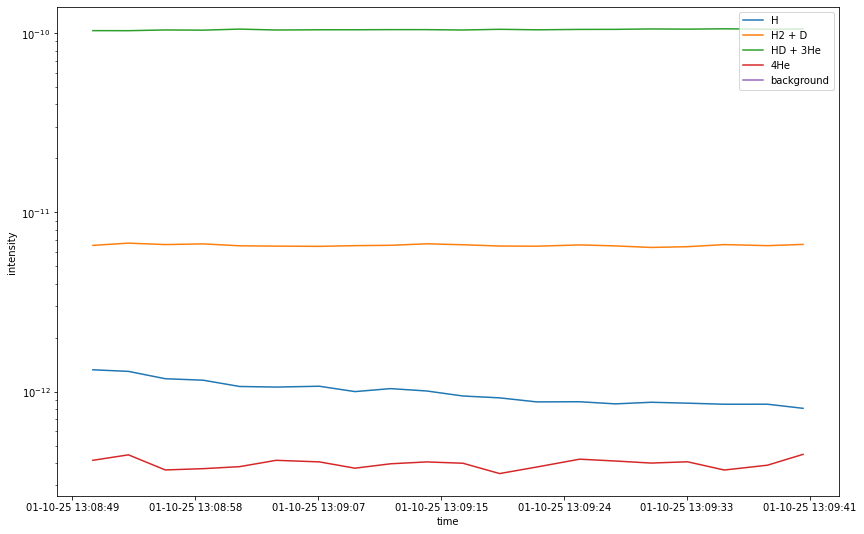

In [296]:
#fill in information here
#for the aliquot type use:
#'lb' for line blank, 'hb' for hot blank, 'std' for standard, 'zirc' for zircon, 'ap' for apatite

aliquot = 'THERMO23_07_F'
aliquot_type = 'ap'
QST = 11363
QRT = 1829

#finding the file
file_name_list = os.listdir('.')
actuation = str(QST*2)

for file in file_name_list:
    if actuation in file:
        file_name = file
        
#creating prisma data list
Prisma_data_list = []
with open(file_name, mode='r') as in_file:
    csv_reader_He = csv.reader(in_file)
    
    #throw away first line of headers
    next(csv_reader_He)
    
    #read in the data lines to a list of lists until the end
    for line in csv_reader_He:
        #throw away empty rows in between lines
        if any(line):
            Prisma_data = [float(i) for i in line[:7]]
            Prisma_data_list.append(Prisma_data)


#convert data_list to an array for easier indexing
Prisma_data_array=np.array(Prisma_data_list)

aliquot_time = Prisma_data_array[-1,1]

#create time list (x-values) and corrected 4He/3He list (y-values)
t_list = [(Prisma_data_array[i,1]-Prisma_data_array[0,1]) for i in range(len(Prisma_data_array))]
He_ratio_list = [(Prisma_data_array[i,5]-Prisma_data_array[i,6])/(Prisma_data_array[i,4]-Prisma_data_array[i,6]-0.005*Prisma_data_array[i,2]) for i in range(len(Prisma_data_array))]

#do some math to find the intercept and mean of the corrected 4He/3He
sum_t_y = 0
sum_t2 = 0
sum_slope_err = 0

for i in range(len(t_list)):
    sum_t_y = sum_t_y + t_list[i]*He_ratio_list[i]
    sum_t2 = sum_t2 + t_list[i]**2

slope = (len(t_list)*sum_t_y - sum(t_list)*sum(He_ratio_list))/(len(t_list)*sum_t2 - sum(t_list)**2)
intercept = (sum(He_ratio_list) - slope*sum(t_list))/len(t_list)

for i in range(len(t_list)):
    sum_slope_err = sum_slope_err + (He_ratio_list[i] - intercept - slope*t_list[i])**2

del_slope = math.sqrt(sum_slope_err/(len(t_list) - 2)) * math.sqrt(len(t_list)/(len(t_list)*sum_t2 - sum(t_list)**2))
del_intercept = math.sqrt(sum_slope_err/(len(t_list) - 2)) * math.sqrt(sum_t2/(len(t_list)*sum_t2 - sum(t_list)**2))

mean_4He_3He = np.mean(He_ratio_list)
stdev_4He_3He = np.std(He_ratio_list)

print('The intercept and error for {0}, listed as a {1}, is: '.format(aliquot,aliquot_type))
print('{0:.5f} +/- {1:.5f}'.format(intercept,del_intercept))
print('and the mean and std dev is: ')
print('{0:.5f} +/- {1:.5f}'.format(mean_4He_3He,stdev_4He_3He))

#precent of re-extract relative to original sample
if aliquot[-4:-1] == '_re':
    
    aliquot_extractions = 0
    aliquot_total = intercept
    hb_time_diff = aliquot_time
    aliquot_prefix = aliquot.split('_re')
    
    for i in range(len(aliquot_frame)):
        temp_name = aliquot_frame.index[i]
        
        #find all of the re-extracts for a sample
        if temp_name.startswith(aliquot_prefix[0]):
            aliquot_total = aliquot_total + aliquot_frame.intercept[i]
            aliquot_extractions = aliquot_extractions + 1
        
        #find the nearest (in time) hot blank
        if aliquot_frame.aliquot_type[i] == 'hb' and abs(aliquot_frame.time_of_collection[i] - aliquot_time) < hb_time_diff:
            closest_hb = aliquot_frame.intercept[i]
            hb_time_diff = abs(aliquot_frame.time_of_collection[i] - aliquot_time)
    
    reextract_percent = 100 * (intercept - closest_hb)/(aliquot_total - aliquot_extractions * closest_hb)
    
    print('The percent of this re-extract from the total gas release so far is: {0:.2f}'.format(reextract_percent))

#show graph of masses through time
seconds_list = []
for i in range(len(Prisma_data_array[:,1])):
    time_since_epoch = datetime.fromtimestamp(Prisma_data_array[i,1])
    seconds_list.append(mdate.date2num(time_since_epoch))
date_fmt = '%m-%d-%y %H:%M:%S'
date_formatter = mdate.DateFormatter(date_fmt)

plt.figure(figsize = (14,9))
plt.ylabel('intensity')
plt.yscale('log')
plt.xlabel('time')
plt.plot(seconds_list, Prisma_data_array[:,2], label = 'H')
plt.plot(seconds_list, Prisma_data_array[:,3], label = 'H2 + D')
plt.plot(seconds_list, Prisma_data_array[:,4], label = 'HD + 3He')
plt.plot(seconds_list, Prisma_data_array[:,5], label = '4He')
plt.plot(seconds_list, Prisma_data_array[:,6], label = 'background')
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.legend()
plt.show()

Now you're ready to add these data to the running line summary list for your run. __If you do not want the data to be added to the running list do not run the next cell.__ There are various reasons why you might not want to add this particular aliquot to the running total. For example, typically the first line blank of the day comes in with a slightly high 4He/3He ratio due to static conditions in the line (valves closed for a prolonged period of time) and we discard it.

If you do want to add these data to the line summary list, click run in the next cell below to proceed. __Add any important sample notes to the sample data frame by filling in the '' next to the notes variable.__ The assumption here is that all data added to a given line summary list will be in chronologic order. This becomes particularly important for re-extract calculation. __Make sure that the sample extraction tied to a specific set of re-extracts is loaded into the aliquot frame before the re-extract.__

In [308]:
#add sample/run to sample data frame
#enter in any notes you have in the notes variable below

notes = ''

#creates a new aliquot_frame if none exists
if 'aliquot_frame' not in locals():
    aliquot_frame = pd.DataFrame(columns = ['aliquot_type','intercept','error','QST','QRT','notes','time_of_collection','file'], index = [])

file_check = False
for name_of_file in aliquot_frame.file:
    if name_of_file == file_name:
        file_check = True
        
if file_check:
    print("You've used the same file twice! Double check your QST and rerun this cell!")
else:
    row_data = pd.DataFrame({'aliquot_type':aliquot_type.lower(), 'intercept':intercept,'error':del_intercept,
                             'QST':QST, 'QRT':QRT, 'notes':notes, 'time_of_collection':aliquot_time,'file':file_name },
                            columns = ['aliquot_type','intercept','error','QST','QRT','notes','time_of_collection','file'], index = [aliquot])
    aliquot_frame = pd.concat([aliquot_frame, row_data])
    #updates the file everytime you add a row, comment out the line below to stop overwriting the file
    aliquot_frame.to_csv(project + '_He_data.csv')  

display(aliquot_frame)


You've used the same file twice! Double check your QST and rerun this cell!


,aliquot_type,intercept,error,QST,QRT,notes,time_of_collection,file
hb01_01072025,hb,0.003237,0.000076,11230,1809,NaN,1.736267e+09,10000-7313-22460-001.csv
lb05_01072025,lb,0.003116,0.000073,11229,1809,NaN,1.736267e+09,10000-7312-22458-001.csv
hb02_01072024,hb,0.003178,0.000057,11232,1810,NaN,1.736270e+09,10000-7314-22464-001.csv
std_1811,std,1.225923,0.002488,11233,1811,NaN,1.736271e+09,10000-7315-22466-001.csv
Durango_M,ap,0.312551,0.000700,11234,1811,NaN,1.736272e+09,10000-7316-22468-001.csv
THERMO_17_A,ap,0.164274,0.000410,11235,1811,NaN,1.736273e+09,10000-7317-22470-001.csv
THERMO_17_B,ap,0.011543,0.000147,11236,1811,NaN,1.736273e+09,10000-7318-22472-001.csv
THERMO_17_C,ap,0.414309,0.001325,11237,1811,NaN,1.736274e+09,10000-7319-22474-001.csv
THERMO_17_D,ap,0.075825,0.000712,11238,1811,NaN,1.736275e+09,10000-7320-22476-001.csv
THERMO_17_E,ap,0.154145,0.000499,11239,1811,NaN,1.736276e+09,10000-7321-22478-001.csv


This last step organizes and reduces your data for export to a json file that we use to further reduce the data once U, Th, and Sm information has been collected. Here, the notebook reports out blank corrected, 4He volumes (in ncc) and amounts (in nmols) for each sample aliquot. We use the hot blank as the blank correction as it most closely resembles the valve procedures for running samples. The line blank could be substituted here. __You will only need to run this once at the end to export the data.__

In [306]:
#initialize reference list of lists and sample dictionary, ref lists tie running means to specific samples
std_num_list = []
hb_ref_list = []
lb_ref_list = []
std_ref_list = []
sample_dict = {}

#initialize sample times and reference numbers used to tie samples to relevant running means 
last_hb_time = 0
last_lb_time = 0
last_std_time = 0
std_ref_num = 0
lb_ref_num = 0
hb_ref_num = 0

#selection statements to determine type of aliquot and what to do with it
#blanks and standards have additional selection statements in order to reset running means at the start of a new analysis day
#re-extracts are dealt with by adding their totals to the correct sample
#re-extracts require that the bulk sample extraction comes BEFORE the re-extract in the aliquot frame

for i in range(len(aliquot_frame)):
    
    aliquot_name = aliquot_frame.index[i]
    aliquot_time = aliquot_frame.time_of_collection[i]
    aliquot_date = date.fromtimestamp(aliquot_time)
    aliquot_hour = datetime.fromtimestamp(aliquot_time).hour
    
    if aliquot_frame.aliquot_type[i] == 'hb':
        if aliquot_date == date.fromtimestamp(last_hb_time) or aliquot_hour < 5:
            hb_list.append(aliquot_frame.intercept[i])
            hb_mean = np.mean(hb_list)
            hb_err = np.std(hb_list)
            hb_ref_list[hb_ref_num] = [hb_mean, hb_err]
            last_hb_time = aliquot_time
        else:
            #reset hb_list if it's a new analysis "day", 5 am used here as cutoff as some users might work after midnight
            hb_list = []
            hb_list.append(aliquot_frame.intercept[i])
            hb_ref_list.append([hb_list[0], aliquot_frame.error[i]])
            last_hb_time = aliquot_time
            if len(hb_ref_list)>1:
                hb_ref_num = hb_ref_num + 1
    elif aliquot_frame.aliquot_type[i] == 'lb':
        if aliquot_date == date.fromtimestamp(last_lb_time) or aliquot_hour < 5:
            lb_list.append(aliquot_frame.intercept[i])
            lb_mean = np.mean(lb_list)
            lb_err = np.std(lb_list)
            lb_ref_list[lb_ref_num] = [lb_mean, lb_err]
            last_lb_time = aliquot_time
        else:
            #reset lb_list if it's a new analysis "day", 5 am used here as cutoff as some users might work after midnight
            lb_list = []
            lb_list.append(aliquot_frame.intercept[i])
            lb_ref_list.append([lb_list[0], aliquot_frame.error[i]])
            last_lb_time = aliquot_time
            if len(lb_ref_list)>1:
                lb_ref_num = lb_ref_num + 1
    elif aliquot_frame.aliquot_type[i] == 'std':
        if aliquot_date == date.fromtimestamp(last_std_time) or aliquot_hour < 5:
            std_list.append(aliquot_frame.intercept[i])
            std_num_list.append(aliquot_frame.QRT[i])
            std_num = np.mean(std_num_list)
            std_mean = np.mean(std_list)
            std_err = np.std(std_list)
            std_ref_list[std_ref_num] = [std_mean, std_err, std_num]
            last_std_time = aliquot_time
        else:
            #reset std_list if it's a new analysis "day", 5 am used here as cutoff as some users might work after midnight
            std_list = []
            std_list.append(aliquot_frame.intercept[i])
            std_num_list = []
            std_num_list.append(aliquot_frame.QRT[i])
            std_ref_list.append([std_list[0], aliquot_frame.error[i], std_num_list[0]])
            last_std_time = aliquot_time
            if len(std_ref_list)>1:
                std_ref_num = std_ref_num + 1
    elif aliquot_name[-4:-1] == '_re':
        reextract_sample = aliquot_name.split('_re')
        update_list = sample_dict[reextract_sample[0]]
        update_list[0] = update_list[0] + aliquot_frame.intercept[i]
        update_list[1] = update_list[1] + aliquot_frame.error[i]
        update_list[2] = update_list[2] + 1
        sample_dict[reextract_sample[0]] = update_list
    else:      
        sample_dict[aliquot_name] = [aliquot_frame.intercept[i], aliquot_frame.error[i], 0, aliquot_time, lb_ref_num, hb_ref_num, std_ref_num, aliquot_frame.notes[i], aliquot_frame.aliquot_type[i]]

#csv file for Ft entry that gets reported out
csv_Ft_file = project + '_Ft_data.csv'

if os.path.exists(csv_Ft_file):
    print('Attempted overwrite of Ft file, old file preserved')
else:
    with open(csv_Ft_file, 'w', newline='') as Ft_file:
        csv_writer = csv.writer(Ft_file)
        csv_writer.writerow(['L1, L2 = maximum length of Crystal (including tips, in two orientations)'])
        csv_writer.writerow(['W1, W2 = mutually perpendicular widths of orthorhombic prism or equatorial diameters'])
        csv_writer.writerow(['h1, h2 = tip heights of pyramidal terminations (zircons only)'])
        csv_writer.writerow(['AI = abrasion index:'])
        csv_writer.writerow(['apatite: 1 = both tips present, 1.5 = one tip missing, 2 = both tips missing, DUR = durango'])
        csv_writer.writerow(['zircon: 1-5 (1=euhedral, 5=rounded, 3=still has pyramids)'])
        csv_writer.writerow('')
    
        header = ['sample_name','morph_comments', 'AI', 'L1_(um)', 'L2_(um)', 'W1_(um)', 'W2_(um)', 'h1_(um)', 'h2_(um)']
        sample_names = [name for name in sample_dict]
        csv_writer.writerow(header)
        for line in sample_names:
            csv_writer.writerow([line])
     
#json dictionary that gets reported out
json_out_dict = {}

#for loop that steps through elements of sample_dict, converts to volume and amount, and adds to the json_out_dict
for index in sample_dict:
    
    std_ncc = initial_tank_4He * tank_depletion**std_ref_list[sample_dict[index][6]][2]
    std_ncc_1s = initial_tank_4He_1s * tank_depletion**std_ref_list[sample_dict[index][6]][2]
    sample_vol = ((sample_dict[index][0] - (sample_dict[index][2] + 1)*hb_ref_list[sample_dict[index][5]][0])/
                    (std_ref_list[sample_dict[index][6]][0]-hb_ref_list[sample_dict[index][5]][0])) * std_ncc
    sample_mol = sample_vol * 1e-12/ideal_gas_moles
    
    #propagate errors
    d_ncc4He_d_samp = std_ncc/(std_ref_list[sample_dict[index][6]][0] - hb_ref_list[sample_dict[index][5]][0])
    d_ncc4He_d_stdncc = (sample_dict[index][0] - hb_ref_list[sample_dict[index][5]][0])/(std_ref_list[sample_dict[index][6]][0] - hb_ref_list[sample_dict[index][5]][0])
    d_ncc4He_d_std = -(sample_dict[index][0] - hb_ref_list[sample_dict[index][5]][0])*std_ncc/(std_ref_list[sample_dict[index][6]][0] - hb_ref_list[sample_dict[index][5]][0])**2
    sample_vol_err = math.sqrt(sample_dict[index][1]**2 * d_ncc4He_d_samp**2 + std_ncc_1s**2 * d_ncc4He_d_stdncc**2
                               + std_ref_list[sample_dict[index][6]][1]**2 * d_ncc4He_d_std**2)
    sample_mol_err = sample_vol_err * 1e-12/ideal_gas_moles
    
    #add to the json_dict
    json_out_dict[index] = [sample_vol, sample_vol_err, sample_mol, sample_mol_err, sample_dict[index][7], sample_dict[index][8]]
    
#send the dict to a json file
json_file = project + '_He_data.json'

with open(json_file, 'w') as out_file:
    json.dump(json_out_dict, out_file)

Attempted overwrite of Ft file, old file preserved


Once you have successfully exported your data and confirmed that the file is safe and sound, save and exit the notebook.